<a href="https://colab.research.google.com/github/LucasLessa1/challengeBain/blob/main/Desafio_Bain_%26_Company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1 - Imports**
First, we import the libraries that will be used throughout the code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import gdown

In [2]:
# !pip install mysql-connector-python

#**2 - Pre-Processing**
Then we import the data into the notebook. It is important to note that once the data was sent by the organizers (in .csv format), the group decided to save it on an AWS RDS instance. the organizers at Bain would have no problems running the code.

Then we import the data into the notebook. It is important to note that as soon as the data was sent by the organizers (in .csv format), the group decided to save it in a folder in Google Drive. That way, the organizers at Bain would have no problems running the code.

In [3]:
#download data csv

def download(id):
  url = 'https://drive.google.com/uc?id=' + str(id)
  gdown.download(url, output = None, quiet = False)


download('1ysfB1yjSXUVn-pxo2Y5mlnNJo6d9JdjG')

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ysfB1yjSXUVn-pxo2Y5mlnNJo6d9JdjG 



In [4]:
df = pd.read_csv('historical-database.csv',delimiter =";")

In [5]:
df.rename(columns = {'destinated_area,':'destinated_area'}, inplace = True)
df

,year,city_code,product_type,product,destinated_area
0,01/01/1974,960b4f2c94a2fb2c,temporary,Others,"0,"
1,01/01/1974,746cc42bfb8f6b62,temporary,Others,"0,"
2,01/01/1974,6cce2bf873870afc,temporary,Others,"0,"
3,01/01/1974,4de42e351006a2ae,temporary,Others,"0,"
4,01/01/1974,5b6072f8f6d37acc,temporary,Others,"0,"
...,...,...,...,...,...
73739,01/01/2013,74d75dde6dc4a5ec,pasture,Livestock,"150866,5644"
73740,01/01/2014,74d75dde6dc4a5ec,pasture,Livestock,"152446,396"
73741,01/01/2015,74d75dde6dc4a5ec,pasture,Livestock,"154681,0205"
73742,01/01/2016,74d75dde6dc4a5ec,pasture,Livestock,"164706,2778"


In [6]:
df = df.astype(str)


In [7]:
df.loc[df['destinated_area'] ==",", 'destinated_area'] = np.nan

df['destinated_area'].isna().sum()

39035

In [8]:
df['destinated_area'] = df['destinated_area'].replace(['0,'],'0')
destinated_area = df['destinated_area'].to_list()
destinated_area = [item if type(item) ==float else item.replace(",", ".") for item in destinated_area]
df['destinated_area'] = destinated_area

In [9]:
df['destinated_area'].isna().sum()

39035

In [10]:
df['destinated_area'] = df['destinated_area'].astype(float) 

In [11]:
column_mean = df["destinated_area"].mean()
df['destinated_area'] = df['destinated_area'].fillna(column_mean)

In [12]:
(df==0).sum()

year                  0
city_code             0
product_type          0
product               0
destinated_area    5643
dtype: int64

In [13]:
df['date'] = pd.to_datetime(df['year'],format= "%d/%m/%Y")

In [14]:
df['year'] = pd.DatetimeIndex(df['date']).year


# **3 - Importing other databases**

In [15]:
download("1uQnV90A0SAFT1KxwjjUOBX4W9zkbZ-Vd") #https://drive.google.com/file/d/1uQnV90A0SAFT1KxwjjUOBX4W9zkbZ-Vd/view?usp=sharing
download('1RII2akbU72zngbRdUpFGIakxcmRoqTPN') #https://drive.google.com/file/d/1RII2akbU72zngbRdUpFGIakxcmRoqTPN/view?usp=sharing
download('1EY28_qJTSq8e0JHEfbeADPSkFCp2kV-T') #https://drive.google.com/file/d/1EY28_qJTSq8e0JHEfbeADPSkFCp2kV-T/view?usp=sharing
download('10RCbzvXP4-ssYLoFQsY8Meubqa8q4IX5') #https://drive.google.com/file/d/10RCbzvXP4-ssYLoFQsY8Meubqa8q4IX5/view?usp=sharing

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1uQnV90A0SAFT1KxwjjUOBX4W9zkbZ-Vd 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1RII2akbU72zngbRdUpFGIakxcmRoqTPN 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1EY28_qJTSq8e0JHEfbeADPSkFCp2kV-T 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10RCbzvXP4-ssYLoFQsY8Meubqa8q4IX5 



Reading the other datasets

In [16]:
df_products = pd.read_csv("/content/products_final.csv")
df_met = pd.read_csv("/content/Meteorologia_Para_2003_2020.csv")
df_umidade = pd.read_csv("/content/lucasDataSet.csv")
df_pecuaria = pd.read_csv("/content/dataframe_final.csv")

In [17]:
# df.merge(df_pecuaria, on=['year', 'product'], how='left')

In [18]:
del df_products['Quantidade produzida (mil frutos)']
del df_products['Rendimento médio da produção (mil frutos por Hectare)']

In [19]:
del df_products["index"]
df_products.head(1)

,Unnamed: 0,Ano,Produto,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares)
0,0,2000.0,Outros,17424.0,726262.932907,3872.0,1252.0,1266.0


In [20]:
di = {"Arroz": "Rice", "Cacau": "Cocoa", "Soja": "Soy","Feijão":"Beans","Coco":"Others","Mandioca":"Cassava","Milho":"Corn","Maracujá":"Others" ,"Café":"Others", "Borracha":"Others" ,"Mamão":"Others", "Limão":"Others", "Algodão arbóreo":"Others", "Algodão herbáceo":"Others" ,"Sorgo":"Sorghum","Cacau":"Cocoa","Dendê":"Palm oil","Açaí":"Açaí","Outros":"Others"}
df_products['Produto'].replace(di, inplace=True)

In [21]:
df_products['Produto'].value_counts()

Others      360
Rice         20
Cocoa        20
Palm oil     20
Beans        20
Cassava      20
Corn         20
Soy          20
Sorghum      20
Açaí          6
Name: Produto, dtype: int64

In [22]:
df_products = df_products[df_products['Produto'] != "Others"]
df_products['Produto'].value_counts()

Rice        20
Cocoa       20
Palm oil    20
Beans       20
Cassava     20
Corn        20
Soy         20
Sorghum     20
Açaí         6
Name: Produto, dtype: int64

In [23]:
df_met.head(1)

,DATA..YYYY.MM.DD.,HORA..UTC.,PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.,TEMPERATURA.DO.PONTO.DE.ORVALHO...C.,TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,X
0,2004-01-01,00:00,0.0,1008.3,1008.8,1007.9,-9999.0,27.4,24.4,27.5,27.3,24.5,24.4,85.0,84.0,84.0,40.0,4.0,1.7,NaN


In [24]:
index = []
x,y = df_met.shape

for i in range(0,x,1):
  index.append(i)

df_met.insert(0, "Unnamed: 0", index, allow_duplicates = False)

In [25]:
df_met

,Unnamed: 0,DATA..YYYY.MM.DD.,HORA..UTC.,PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.,TEMPERATURA.DO.PONTO.DE.ORVALHO...C.,...,TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,X
0,0,2004-01-01,00:00,0.0,1008.3,1008.8,1007.9,-9999.0,27.4,24.4,...,27.3,24.5,24.4,85.0,84.0,84.0,40.0,4.0,1.7,NaN
1,1,2004-01-01,01:00,0.0,1008.9,1008.9,1008.3,-9999.0,27.1,24.3,...,26.8,24.4,24.3,87.0,84.0,84.0,69.0,3.9,0.8,NaN
2,2,2004-01-01,02:00,0.0,1008.6,1009.0,1008.3,-9999.0,26.7,24.1,...,26.7,24.3,24.1,86.0,84.0,86.0,81.0,4.7,0.4,NaN
3,3,2004-01-01,03:00,0.0,1008.5,1008.7,1008.3,-9999.0,26.7,24.1,...,26.6,24.2,24.1,86.0,86.0,86.0,56.0,3.6,0.7,NaN
4,4,2004-01-01,04:00,0.0,1008.2,1008.5,1008.2,-9999.0,26.2,24.2,...,26.2,24.2,24.1,89.0,86.0,89.0,124.0,2.5,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157339,157339,2003-12-31,19:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
157340,157340,2003-12-31,20:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
157341,157341,2003-12-31,21:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN
157342,157342,2003-12-31,22:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,NaN


In [26]:
df_met.columns

Index(['Unnamed: 0', 'DATA..YYYY.MM.DD.', 'HORA..UTC.',
       'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
       'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
       'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
       'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
       'RADIACAO.GLOBAL..KJ.m².',
       'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
       'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
       'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.',
       'UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....',
       'UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....',
       'UMIDADE.RELATIVA.DO.AR..HORARIA....',
       'VENTO..DIREÇÃO.HORARIA..gr......gr..', 'VENTO..RAJADA.MAXIMA..m.s.',
       'VENTO..VELOCIDADE.HORARIA..m.s.', 'X'],
      dtype='object')

In [27]:
df_met['date'] = pd.to_datetime(df_met['DATA..YYYY.MM.DD.'],format= "%Y/%m/%d")

df_met['DATA..YYYY.MM.DD.'] = pd.DatetimeIndex(df_met['date']).year

In [28]:
df_met.rename(columns = {'DATA..YYYY.MM.DD.':'Ano'}, inplace = True)

In [29]:
df_met = df_met.replace(-9999.0,np.NaN)

In [30]:
df_met

,Unnamed: 0,Ano,HORA..UTC.,PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.,TEMPERATURA.DO.PONTO.DE.ORVALHO...C.,...,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,X,date
0,0,2004,00:00,0.0,1008.3,1008.8,1007.9,NaN,27.4,24.4,...,24.5,24.4,85.0,84.0,84.0,40.0,4.0,1.7,NaN,2004-01-01
1,1,2004,01:00,0.0,1008.9,1008.9,1008.3,NaN,27.1,24.3,...,24.4,24.3,87.0,84.0,84.0,69.0,3.9,0.8,NaN,2004-01-01
2,2,2004,02:00,0.0,1008.6,1009.0,1008.3,NaN,26.7,24.1,...,24.3,24.1,86.0,84.0,86.0,81.0,4.7,0.4,NaN,2004-01-01
3,3,2004,03:00,0.0,1008.5,1008.7,1008.3,NaN,26.7,24.1,...,24.2,24.1,86.0,86.0,86.0,56.0,3.6,0.7,NaN,2004-01-01
4,4,2004,04:00,0.0,1008.2,1008.5,1008.2,NaN,26.2,24.2,...,24.2,24.1,89.0,86.0,89.0,124.0,2.5,0.0,NaN,2004-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157339,157339,2003,19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-12-31
157340,157340,2003,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-12-31
157341,157341,2003,21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-12-31
157342,157342,2003,22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-12-31


In [31]:
df_met = df_met.groupby('Ano', as_index=False).mean()

In [32]:
df_met.shape

(18, 20)

In [33]:
df_met.rename(columns={'Ano':'year'}, inplace=True)


In [34]:
df_met.columns

Index(['year', 'Unnamed: 0', 'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
       'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
       'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
       'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
       'RADIACAO.GLOBAL..KJ.m².',
       'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
       'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
       'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.',
       'UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....',
       'UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....',
       'UMIDADE.RELATIVA.DO.AR..HORARIA....',
       'VENTO..DIREÇÃO.HORARIA..gr......gr..', 'VENTO..RAJADA.MAXIMA..m.s.',
       'VENTO..VELOCIDADE.HORARIA..m.s.', 'X'],
      dtype='object')

##Selecting 2018 and 2019 

In [35]:
df_merge =df_umidade.merge(df_products,on="Ano",how='left')
df_merge.rename(columns={'Ano':'year'}, inplace=True)

df_merge = df_merge.merge(df_met, on="year", how='left')
df_merge = df_merge.merge(df, on="year", how='left')

pred_2018 = df_merge[df_merge['year'] == 2018]
pred_2019 = df_merge[df_merge['year'] == 2019]

del pred_2018['Unnamed: 0_x']
del pred_2018['Unnamed: 0_y']
del pred_2018['X']
del pred_2018['date']
del pred_2018['product']


del pred_2019['Unnamed: 0_x']
del pred_2019['Unnamed: 0_y']
del pred_2019['X']
del pred_2019['date']
del pred_2019['product']

In [36]:
pred_2018

,year,firespots,Deforestation area (km²) in PARÁ,Perda de cobertura arbórea de umidade (Ha),emissão de gases estufa,Produto,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),...,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,city_code,product_type,destinated_area
255088,2018,22080,2744.0,820257.448827,5.285792e+08,Açaí,2461398.0,6.875214e+05,5206796.0,343994.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255089,2018,22080,2744.0,820257.448827,5.285792e+08,Rice,228070.0,1.559757e+05,156348.0,78062.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255090,2018,22080,2744.0,820257.448827,5.285792e+08,Cocoa,220120.0,4.054542e+04,2099314.0,257926.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255091,2018,22080,2744.0,820257.448827,5.285792e+08,Palm oil,4409062.0,4.081425e+05,1097574.0,297478.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255092,2018,22080,2744.0,820257.448827,5.285792e+08,Beans,41168.0,7.971622e+04,81502.0,54224.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255093,2018,22080,2744.0,820257.448827,5.285792e+08,Cassava,7672430.0,1.996111e+06,3294992.0,522616.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255094,2018,22080,2744.0,820257.448827,5.285792e+08,Corn,1581930.0,2.816709e+05,915788.0,453416.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255095,2018,22080,2744.0,820257.448827,5.285792e+08,Soy,3276938.0,7.984579e+04,3488068.0,1115064.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN
255096,2018,22080,2744.0,820257.448827,5.285792e+08,Sorghum,26532.0,1.195786e+04,9198.0,8970.0,...,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN,NaN,NaN


In [37]:
pred_2018 = pred_2018.drop(["city_code","destinated_area"], axis=1)
pred_2019 = pred_2019.drop(["city_code","destinated_area"], axis=1)
pred_2018.rename(columns={'Produto':'product'}, inplace=True)
pred_2019.rename(columns={'Produto':'product'}, inplace=True)



pred_2018

,year,firespots,Deforestation area (km²) in PARÁ,Perda de cobertura arbórea de umidade (Ha),emissão de gases estufa,product,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),...,TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,product_type
255088,2018,22080,2744.0,820257.448827,5.285792e+08,Açaí,2461398.0,6.875214e+05,5206796.0,343994.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255089,2018,22080,2744.0,820257.448827,5.285792e+08,Rice,228070.0,1.559757e+05,156348.0,78062.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255090,2018,22080,2744.0,820257.448827,5.285792e+08,Cocoa,220120.0,4.054542e+04,2099314.0,257926.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255091,2018,22080,2744.0,820257.448827,5.285792e+08,Palm oil,4409062.0,4.081425e+05,1097574.0,297478.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255092,2018,22080,2744.0,820257.448827,5.285792e+08,Beans,41168.0,7.971622e+04,81502.0,54224.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255093,2018,22080,2744.0,820257.448827,5.285792e+08,Cassava,7672430.0,1.996111e+06,3294992.0,522616.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255094,2018,22080,2744.0,820257.448827,5.285792e+08,Corn,1581930.0,2.816709e+05,915788.0,453416.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255095,2018,22080,2744.0,820257.448827,5.285792e+08,Soy,3276938.0,7.984579e+04,3488068.0,1115064.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN
255096,2018,22080,2744.0,820257.448827,5.285792e+08,Sorghum,26532.0,1.195786e+04,9198.0,8970.0,...,26.054391,23.215754,22.353669,83.259502,78.122545,80.79015,115.244057,3.308219,0.659832,NaN


In [38]:
pred_2019

,year,firespots,Deforestation area (km²) in PARÁ,Perda de cobertura arbórea de umidade (Ha),emissão de gases estufa,product,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),...,TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,product_type
255097,2019,29700,3862.0,693042.511328,4.550097e+08,Açaí,2640300.0,7.450415e+05,5760430.0,376030.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255098,2019,29700,3862.0,693042.511328,4.550097e+08,Rice,189016.0,1.424274e+05,150382.0,76482.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255099,2019,29700,3862.0,693042.511328,4.550097e+08,Cocoa,257922.0,4.529278e+04,2394816.0,281028.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255100,2019,29700,3862.0,693042.511328,4.550097e+08,Palm oil,5087628.0,4.379300e+05,1273392.0,328340.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255101,2019,29700,3862.0,693042.511328,4.550097e+08,Beans,41766.0,7.516838e+04,97300.0,54928.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255102,2019,29700,3862.0,693042.511328,4.550097e+08,Cassava,7422428.0,1.894349e+06,3037060.0,524042.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255103,2019,29700,3862.0,693042.511328,4.550097e+08,Corn,1655440.0,2.500713e+05,964364.0,518244.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255104,2019,29700,3862.0,693042.511328,4.550097e+08,Soy,3563344.0,1.009487e+05,3971176.0,1155528.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
255105,2019,29700,3862.0,693042.511328,4.550097e+08,Sorghum,79542.0,2.140086e+04,31336.0,41302.0,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN


Add the products witch is not in our dataset

In [39]:
df.groupby("product")["product_type"].unique()

product
Açaí                    [permanent]
Beans                   [temporary]
Cassava                 [temporary]
Cocoa                   [permanent]
Corn                    [temporary]
Livestock                 [pasture]
Others       [temporary, permanent]
Palm oil                [permanent]
Rice                    [temporary]
Sorghum                 [temporary]
Soy                     [temporary]
Name: product_type, dtype: object

In [40]:
#==================2018===================
new_others = pd.Series(data={"product":"Others", "product_type":"temporary"}, name='10')
new_livestock = pd.Series(data={"product":"Livestock", "product_type":"pasture"}, name='11')

pred_2018 = pred_2018.append(new_others, ignore_index=True)
pred_2018 = pred_2018.append(new_livestock, ignore_index=True)


#==================2019===================
new_others = pd.Series(data={"product":"Others", "product_type":"temporary"}, name='10')
new_livestock = pd.Series(data={"product":"Livestock", "product_type":"pasture"}, name='11')

pred_2019 = pred_2019.append(new_others, ignore_index=True)
pred_2019 = pred_2019.append(new_livestock, ignore_index=True)


In [41]:
pred_2018.fillna(pred_2018.mean(), inplace=True)
pred_2019.fillna(pred_2019.mean(), inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [42]:
pred_2019.tail()

,year,firespots,Deforestation area (km²) in PARÁ,Perda de cobertura arbórea de umidade (Ha),emissão de gases estufa,product,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),...,TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.,product_type
6,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Corn,1.655440e+06,250071.325453,9.643640e+05,5.182440e+05,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
7,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Soy,3.563344e+06,100948.736612,3.971176e+06,1.155528e+06,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
8,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Sorghum,7.954200e+04,21400.863154,3.133600e+04,4.130200e+04,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,NaN
9,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Others,2.326376e+06,412514.419861,1.964473e+06,3.728804e+05,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,temporary
10,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Livestock,2.326376e+06,412514.419861,1.964473e+06,3.728804e+05,...,26.235174,23.541338,22.629251,83.641363,78.583857,81.24171,115.456042,3.199303,0.723985,pasture


##Merge -> DataFrame_original with df_products

In [43]:
df_products.rename(columns={'Ano':'year', 'Produto':'product'}, inplace=True)

In [44]:
df_products.columns

Index(['Unnamed: 0', 'year', 'product', 'Quantidade produzida (Toneladas)',
       'Rendimento médio da produção (Quilogramas por Hectare)',
       'Valor da produção (Mil Reais)', 'Área colhida (Hectares)',
       'Área plantada ou destinada à colheita (Hectares)'],
      dtype='object')

In [45]:
df_with_products = df.merge(df_products, on=["year","product"], how="left")

In [46]:
df_with_products["product"].value_counts()

Others       12584
Rice          6292
Beans         6292
Cassava       6292
Corn          6292
Cocoa         6292
Palm oil      6292
Açaí          6292
Sorghum       6204
Soy           6160
Livestock     4752
Name: product, dtype: int64

In [47]:
df_met.columns

Index(['year', 'Unnamed: 0', 'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
       'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
       'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
       'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
       'RADIACAO.GLOBAL..KJ.m².',
       'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
       'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
       'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.',
       'UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....',
       'UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....',
       'UMIDADE.RELATIVA.DO.AR..HORARIA....',
       'VENTO..DIREÇÃO.HORARIA..gr......gr..', 'VENTO..RAJADA.MAXIMA..m.s.',
       'VENTO..VELOCIDADE.HORARIA..m.s.', 'X'],
      dtype='object')

In [48]:
df_total = df_with_products.merge(df_met, on="year", how="left")

In [49]:
df["product"].value_counts()

Others       12584
Rice          6292
Beans         6292
Cassava       6292
Corn          6292
Cocoa         6292
Palm oil      6292
Açaí          6292
Sorghum       6204
Soy           6160
Livestock     4752
Name: product, dtype: int64

In [50]:
df_total["product"].value_counts()

Others       12584
Rice          6292
Beans         6292
Cassava       6292
Corn          6292
Cocoa         6292
Palm oil      6292
Açaí          6292
Sorghum       6204
Soy           6160
Livestock     4752
Name: product, dtype: int64

In [51]:
df_total.columns

Index(['year', 'city_code', 'product_type', 'product', 'destinated_area',
       'date', 'Unnamed: 0_x', 'Quantidade produzida (Toneladas)',
       'Rendimento médio da produção (Quilogramas por Hectare)',
       'Valor da produção (Mil Reais)', 'Área colhida (Hectares)',
       'Área plantada ou destinada à colheita (Hectares)', 'Unnamed: 0_y',
       'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
       'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
       'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
       'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
       'RADIACAO.GLOBAL..KJ.m².',
       'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
       'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
       'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
       'TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.',
       'UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....',
       'UMIDADE.R

In [52]:
del df_total['Unnamed: 0_x']
del df_total['Unnamed: 0_y']
del df_total['X']
del df_total['date']

In [53]:
df.head(1)

,year,city_code,product_type,product,destinated_area,date
0,1974,960b4f2c94a2fb2c,temporary,Others,0.0,1974-01-01


In [54]:
df["product"].unique()

array(['Others', 'Rice', 'Beans', 'Cassava', 'Corn', 'Soy', 'Sorghum',
       'Cocoa', 'Palm oil', 'Açaí', 'Livestock'], dtype=object)

In [55]:
df_total["product"].value_counts()

Others       12584
Rice          6292
Beans         6292
Cassava       6292
Corn          6292
Cocoa         6292
Palm oil      6292
Açaí          6292
Sorghum       6204
Soy           6160
Livestock     4752
Name: product, dtype: int64

In [56]:
df["product"].value_counts()

Others       12584
Rice          6292
Beans         6292
Cassava       6292
Corn          6292
Cocoa         6292
Palm oil      6292
Açaí          6292
Sorghum       6204
Soy           6160
Livestock     4752
Name: product, dtype: int64

In [57]:
df_total["product"].value_counts()

Others       12584
Rice          6292
Beans         6292
Cassava       6292
Corn          6292
Cocoa         6292
Palm oil      6292
Açaí          6292
Sorghum       6204
Soy           6160
Livestock     4752
Name: product, dtype: int64

In [58]:
df_total.head()

,year,city_code,product_type,product,destinated_area,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),...,TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.,TEMPERATURA.ORVALHO.MIN..NA.HORA.ANT...AUT....C.,UMIDADE.REL..MAX..NA.HORA.ANT...AUT.....,UMIDADE.REL..MIN..NA.HORA.ANT...AUT.....,UMIDADE.RELATIVA.DO.AR..HORARIA....,VENTO..DIREÇÃO.HORARIA..gr......gr..,VENTO..RAJADA.MAXIMA..m.s.,VENTO..VELOCIDADE.HORARIA..m.s.
0,1974,960b4f2c94a2fb2c,temporary,Others,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1974,746cc42bfb8f6b62,temporary,Others,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1974,6cce2bf873870afc,temporary,Others,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1974,4de42e351006a2ae,temporary,Others,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1974,5b6072f8f6d37acc,temporary,Others,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##One hot enconding for products

In [59]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df_total[['product', "product_type"]]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df_total.join(encoder_df)

final_df

,year,city_code,product_type,product,destinated_area,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),...,4,5,6,7,8,9,10,11,12,13
0,1974,960b4f2c94a2fb2c,temporary,Others,0.0000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1974,746cc42bfb8f6b62,temporary,Others,0.0000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1974,6cce2bf873870afc,temporary,Others,0.0000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1974,4de42e351006a2ae,temporary,Others,0.0000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1974,5b6072f8f6d37acc,temporary,Others,0.0000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73739,2013,74d75dde6dc4a5ec,pasture,Livestock,150866.5644,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73740,2014,74d75dde6dc4a5ec,pasture,Livestock,152446.3960,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73741,2015,74d75dde6dc4a5ec,pasture,Livestock,154681.0205,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73742,2016,74d75dde6dc4a5ec,pasture,Livestock,164706.2778,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(pred_2018[['product', "product_type"]]).toarray())

#merge one-hot encoded columns back with original DataFrame
pred_2018 = pred_2018.join(encoder_df)

encoder_df = pd.DataFrame(encoder.fit_transform(pred_2019[['product', "product_type"]]).toarray())
pred_2019 = pred_2019.join(encoder_df)



In [61]:
pred_2019

,year,firespots,Deforestation area (km²) in PARÁ,Perda de cobertura arbórea de umidade (Ha),emissão de gases estufa,product,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),...,4,5,6,7,8,9,10,11,12,13
0,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Açaí,2.640300e+06,7.450415e+05,5.760430e+06,3.760300e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Rice,1.890160e+05,1.424274e+05,1.503820e+05,7.648200e+04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Cocoa,2.579220e+05,4.529278e+04,2.394816e+06,2.810280e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Palm oil,5.087628e+06,4.379300e+05,1.273392e+06,3.283400e+05,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Beans,4.176600e+04,7.516838e+04,9.730000e+04,5.492800e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Cassava,7.422428e+06,1.894349e+06,3.037060e+06,5.240420e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Corn,1.655440e+06,2.500713e+05,9.643640e+05,5.182440e+05,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Soy,3.563344e+06,1.009487e+05,3.971176e+06,1.155528e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Sorghum,7.954200e+04,2.140086e+04,3.133600e+04,4.130200e+04,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,2019.0,29700.0,3862.0,693042.511328,4.550097e+08,Others,2.326376e+06,4.125144e+05,1.964473e+06,3.728804e+05,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [62]:
df_total = final_df

In [63]:
df_total.shape

(73744, 41)

##Tratamento

In [64]:
df_total.dtypes

year                                                        int64
city_code                                                  object
product_type                                               object
product                                                    object
destinated_area                                           float64
Quantidade produzida (Toneladas)                          float64
Rendimento médio da produção (Quilogramas por Hectare)    float64
Valor da produção (Mil Reais)                             float64
Área colhida (Hectares)                                   float64
Área plantada ou destinada à colheita (Hectares)          float64
PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.                          float64
PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.     float64
PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.           float64
PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.          float64
RADIACAO.GLOBAL..KJ.m².                                   float64
TEMPERATUR

In [65]:
columns = df_total.columns
columns = columns.drop(["city_code", "product_type", "product"])


In [66]:
#Replacing Nan values
for i in columns:

  df_total[i].fillna(df_total[i].mean(), inplace=True)



In [67]:
df_total.head()

,year,city_code,product_type,product,destinated_area,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),...,4,5,6,7,8,9,10,11,12,13
0,1974,960b4f2c94a2fb2c,temporary,Others,0.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1974,746cc42bfb8f6b62,temporary,Others,0.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1974,6cce2bf873870afc,temporary,Others,0.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1974,4de42e351006a2ae,temporary,Others,0.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1974,5b6072f8f6d37acc,temporary,Others,0.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [68]:
df_total = df_total[df_total['year'] >= 2000]
df_total = df_total[df_total['year'] <= 2017]

In [69]:
df_total.head(3)

,year,city_code,product_type,product,destinated_area,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),...,4,5,6,7,8,9,10,11,12,13
3718,2000,960b4f2c94a2fb2c,temporary,Others,108.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3719,2000,746cc42bfb8f6b62,temporary,Others,0.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3720,2000,6cce2bf873870afc,temporary,Others,10.0,1.745659e+06,367757.391093,693998.57121,266050.720845,268069.059194,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#**4 - Implementing XGBoost**

https://debuggercafe.com/a-guide-to-xgboost-in-python/

https://xgboost.readthedocs.io/en/stable/python/python_intro.html

https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

https://medium.com/towards-data-science/xgboost-predicting-life-expectancy-with-supervised-learning-1f61e0222f5f

In [70]:
# necessary imports
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [71]:
x =df_total.groupby("product").sum()

In [72]:
#rodar todas as features
label = df_total["destinated_area"]
features = df_total.drop(["destinated_area", "city_code", "product_type", "product", "year"], axis=1)

Alinhando as colunas na mesma ordem

In [73]:
columns_total  = features.columns
pred_2018 = pred_2018.reindex(columns=columns_total)
pred_2019 = pred_2019.reindex(columns=columns_total)

pred_2018

,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,...,4,5,6,7,8,9,10,11,12,13
0,2461398.0,6.875214e+05,5206796.0,3.439940e+05,3.440320e+05,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,228070.0,1.559757e+05,156348.0,7.806200e+04,7.806200e+04,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,220120.0,4.054542e+04,2099314.0,2.579260e+05,2.584940e+05,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4409062.0,4.081425e+05,1097574.0,2.974780e+05,2.977580e+05,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,41168.0,7.971622e+04,81502.0,5.422400e+04,5.422400e+04,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,7672430.0,1.996111e+06,3294992.0,5.226160e+05,5.311560e+05,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1581930.0,2.816709e+05,915788.0,4.534160e+05,4.534160e+05,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,3276938.0,7.984579e+04,3488068.0,1.115064e+06,1.115084e+06,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,26532.0,1.195786e+04,9198.0,8.970000e+03,8.970000e+03,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,2213072.0,4.157207e+05,1816620.0,3.479722e+05,3.490218e+05,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
features.columns

Index([                      'Quantidade produzida (Toneladas)',
       'Rendimento médio da produção (Quilogramas por Hectare)',
                                'Valor da produção (Mil Reais)',
                                      'Área colhida (Hectares)',
             'Área plantada ou destinada à colheita (Hectares)',
                             'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
        'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
              'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
             'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
                                      'RADIACAO.GLOBAL..KJ.m².',
                 'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
                         'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
                   'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
                   'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
             'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
             'TEMPERATURA

In [76]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [77]:
# df_scaler = min_max_scaler.fit_transform(features)

df_scaler = scaler.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [78]:
column = features.columns

In [79]:
df_scaler = pd.DataFrame(df_scaler, columns= column)
df_scaler.head(2)

,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,...,4,5,6,7,8,9,10,11,12,13
0,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-1.413074e-13,1.404331e-10,-2.544066e-11,-4.115562e-10,1.264225e-13,...,-0.301895,-0.303046,2.232938,-0.301895,-0.301895,-0.299586,-0.298427,-0.303046,-0.708346,0.847865
1,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-1.413074e-13,1.404331e-10,-2.544066e-11,-4.115562e-10,1.264225e-13,...,-0.301895,-0.303046,2.232938,-0.301895,-0.301895,-0.299586,-0.298427,-0.303046,-0.708346,0.847865


In [80]:
pred_2018.head(2)

,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,...,4,5,6,7,8,9,10,11,12,13
0,2461398.0,687521.351547,5206796.0,343994.0,344032.0,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,228070.0,155975.652020,156348.0,78062.0,78062.0,0.478972,1009.112864,1009.404718,1008.818792,877.315406,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [81]:
label.isna().sum()

0

In [82]:
x_train, x_test, y_train, y_test = train_test_split(df_scaler, label, random_state=42, test_size=0.2)

###Feature Selection

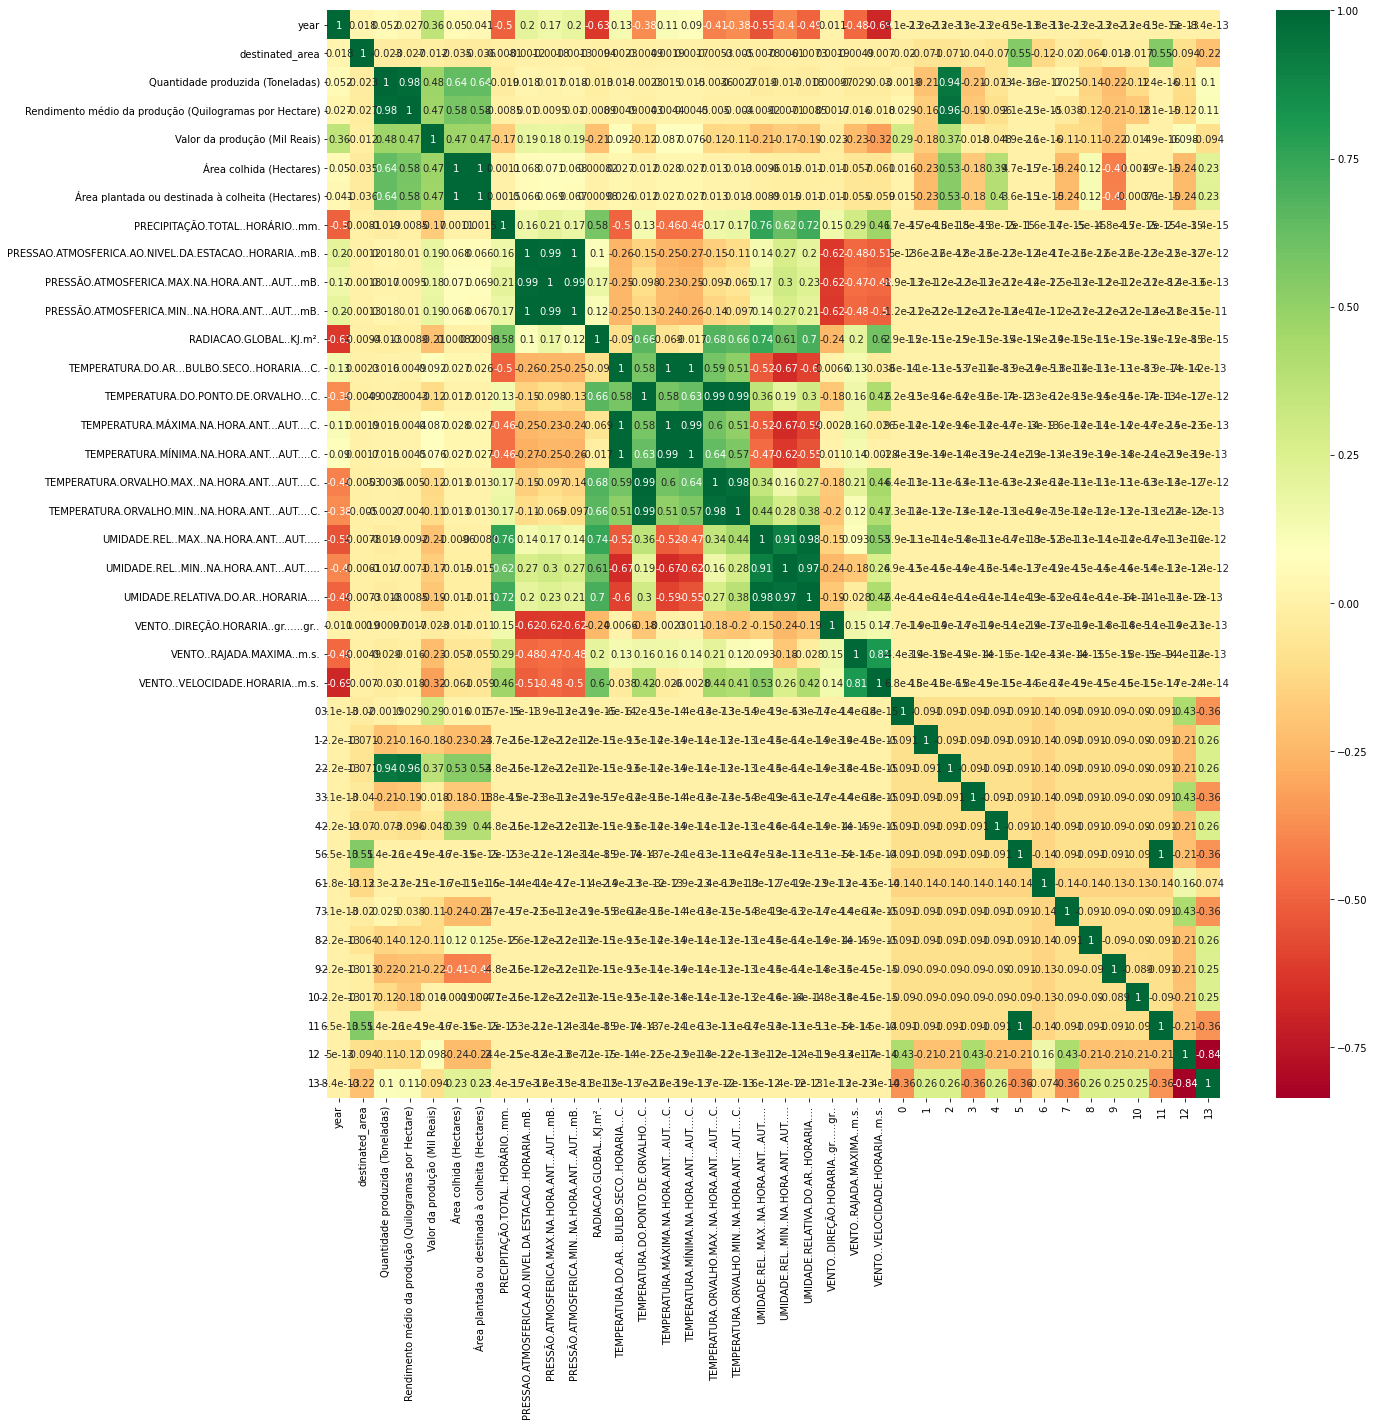

In [83]:
#Correlação
corrmat = df_total.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_total[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [84]:
#trocar para df_scaler se for usar a normalização
# df_scaler["destinated_area"] = label

In [85]:
df_scaler.head(1)

,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,...,4,5,6,7,8,9,10,11,12,13
0,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-1.413074e-13,1.404331e-10,-2.544066e-11,-4.115562e-10,1.264225e-13,...,-0.301895,-0.303046,2.232938,-0.301895,-0.301895,-0.299586,-0.298427,-0.303046,-0.708346,0.847865


In [86]:
xgbr = xgb.XGBRegressor(n_estimators=10000, learning_rate = 0.05, n_jobs=4)

In [87]:
xgbr.fit(x_train, y_train, early_stopping_rounds=5,eval_set=[(x_test, y_test)], verbose=False)

[16:59:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=10000, n_jobs=4)

In [88]:
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.3076355887281159


In [89]:
from sklearn.metrics import mean_squared_error

In [90]:
y_pred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 2086347017.30
RMSE: 45676.55


In [91]:
y_pred

array([  2105.8896 ,   8702.361  ,    756.05756, ...,   3605.8152 ,
       135619.81   ,   2105.8896 ], dtype=float32)

In [92]:
y_test

48753       390.000000
67801     14433.918683
5328          1.000000
48093        30.000000
71978    257067.297300
             ...      
47977        94.000000
37968      8000.000000
39741     14433.918683
72290    315441.336400
50005       713.000000
Name: destinated_area, Length: 6164, dtype: float64

In [93]:
score = xgbr.score(x_test, y_test)  
score

0.31043431803387944

In [94]:
df_scaler.tail()

,Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada ou destinada à colheita (Hectares),PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.,PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.,PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.,PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.,RADIACAO.GLOBAL..KJ.m².,...,4,5,6,7,8,9,10,11,12,13
30811,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-0.658130,-0.108764,-0.147695,-0.132311,-0.770988,...,-0.301895,3.299832,-0.44784,-0.301895,-0.301895,-0.299586,-0.298427,3.299832,-0.708346,-1.179433
30812,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-0.319823,1.133541,1.108408,1.117134,-0.779437,...,-0.301895,3.299832,-0.44784,-0.301895,-0.301895,-0.299586,-0.298427,3.299832,-0.708346,-1.179433
30813,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-1.091630,1.685089,1.664286,1.683045,-0.790805,...,-0.301895,3.299832,-0.44784,-0.301895,-0.301895,-0.299586,-0.298427,3.299832,-0.708346,-1.179433
30814,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-1.116172,1.254861,1.232535,1.244842,-0.790708,...,-0.301895,3.299832,-0.44784,-0.301895,-0.301895,-0.299586,-0.298427,3.299832,-0.708346,-1.179433
30815,0.0,5.428759e-15,0.0,3.054804e-16,0.0,-0.040430,0.449100,0.395584,0.450807,-0.792247,...,-0.301895,3.299832,-0.44784,-0.301895,-0.301895,-0.299586,-0.298427,3.299832,-0.708346,-1.179433


In [96]:
# pred_2018 = pred_2018.drop(["product", "year"], axis=1)
# pred_2019 = pred_2019.drop(["product", "year"], axis=1)
pred_2018.columns

Index([                      'Quantidade produzida (Toneladas)',
       'Rendimento médio da produção (Quilogramas por Hectare)',
                                'Valor da produção (Mil Reais)',
                                      'Área colhida (Hectares)',
             'Área plantada ou destinada à colheita (Hectares)',
                             'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
        'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
              'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
             'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
                                      'RADIACAO.GLOBAL..KJ.m².',
                 'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
                         'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
                   'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
                   'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
             'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
             'TEMPERATURA

In [97]:
pred_2019.columns

Index([                      'Quantidade produzida (Toneladas)',
       'Rendimento médio da produção (Quilogramas por Hectare)',
                                'Valor da produção (Mil Reais)',
                                      'Área colhida (Hectares)',
             'Área plantada ou destinada à colheita (Hectares)',
                             'PRECIPITAÇÃO.TOTAL..HORÁRIO..mm.',
        'PRESSAO.ATMOSFERICA.AO.NIVEL.DA.ESTACAO..HORARIA..mB.',
              'PRESSÃO.ATMOSFERICA.MAX.NA.HORA.ANT...AUT...mB.',
             'PRESSÃO.ATMOSFERICA.MIN..NA.HORA.ANT...AUT...mB.',
                                      'RADIACAO.GLOBAL..KJ.m².',
                 'TEMPERATURA.DO.AR...BULBO.SECO..HORARIA...C.',
                         'TEMPERATURA.DO.PONTO.DE.ORVALHO...C.',
                   'TEMPERATURA.MÁXIMA.NA.HORA.ANT...AUT....C.',
                   'TEMPERATURA.MÍNIMA.NA.HORA.ANT...AUT....C.',
             'TEMPERATURA.ORVALHO.MAX..NA.HORA.ANT...AUT....C.',
             'TEMPERATURA

In [98]:
y_pred_2018 = xgbr.predict(pred_2018)
y_pred_2019 = xgbr.predict(pred_2019)


In [99]:
y_pred_2018

array([4866.53 , 4866.53 , 4866.53 , 4866.53 , 4866.53 , 4866.53 ,
       4866.53 , 4866.53 , 4866.53 , 3369.527, 4866.53 ], dtype=float32)

In [100]:
y_pred_2019

array([4866.53 , 4866.53 , 4866.53 , 4866.53 , 4866.53 , 4866.53 ,
       4866.53 , 4866.53 , 4866.53 , 3369.527, 4866.53 ], dtype=float32)

#**5 - Implementing Linnear Regression**

In [101]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [102]:
label

3718        108.0000
3719          0.0000
3720         10.0000
3721         40.0000
3722         21.0000
            ...     
73739    150866.5644
73740    152446.3960
73741    154681.0205
73742    164706.2778
73743    165220.8728
Name: destinated_area, Length: 30816, dtype: float64

In [103]:
x = features
y = label

In [104]:
x = np.array(x.values.tolist())
y = np.array(y.values.tolist())

model = LinearRegression(normalize=True, n_jobs=-1)

In [105]:
model = LinearRegression().fit(x,y)

In [106]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope: \n', model.coef_)

coefficient of determination: 0.3065474029798936
intercept: -1547022.0697555603
slope: 
 [ 5.25538034e-04 -1.64661568e-02 -9.07974391e-04  6.54537105e-02
 -6.31111345e-02 -1.54241731e+04 -4.33304870e+03 -1.09786760e+02
  6.08170608e+03 -1.67168042e-01  9.13621018e+03  1.14766655e+04
 -8.07630727e+03 -8.93361824e+03  5.43378905e+03 -9.41983300e+03
  2.64124591e+03  1.61076501e+02 -3.48917383e+03  2.18478275e+02
  8.83096027e+02 -4.14421302e+03  2.03432047e+03 -1.32826595e+04
  1.48075724e+04 -8.14889176e+03 -1.17980075e+04  4.59546386e+04
 -1.16961480e+04 -9.33232443e+02 -1.11365659e+04 -2.72400259e+03
 -3.07702382e+03  4.59546386e+04 -2.26278341e+04 -2.33268046e+04]


In [107]:
y_pred = model.predict(x)
y_pred

array([   199.2284387 ,    199.2284387 ,    199.2284387 , ...,
       128226.78480269, 128421.28864076, 128831.01316526])

In [108]:
mse = mean_squared_error(y, y_pred)
mse

2582427359.651658